In [1]:
import os
import cv2
import math
import torch
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm
from utils.func import load_conf_file
from utils.basic_tools import load_image
from torch.distributions import Categorical
from sklearn.metrics import accuracy_score, roc_auc_score

from utils.tools import *
from utils.fully_convnet_tools import get_patch_location, topK_patches
from captum.attr import GuidedBackprop, IntegratedGradients, LayerGradCam, NoiseTunnel, LayerAttribution

In [3]:
def simple_plot(fnames, grades, path_folder, size=(3,3), fs=12):
    fig = plt.figure(figsize=size)
    n = len(fnames)
    j = 0
    
    for i in range(n):
        j += 1
        ax = fig.add_subplot(1, n, j)
        img = plt.imread(os.path.join(path_folder, fnames[i]))
        ax.imshow(img)
        ax.set_title(f"{fnames[i].split('.')[0], grades[i]}", loc="center", fontsize=fs)
        ax.axis('off')
    plt.show()

In [4]:
config_file = './configs/default.yaml'
cfg = load_conf_file(config_file)

# Fundus images

In [7]:
model_weights = '../Model_weights/Fully_ConvNet/'
path = "/gpfs01/berens/data/data/DR/Kaggle_DR_resized/"
img_path = "/gpfs01/berens/data/data/DR/Kaggle_DR_resized/kaggle_data_512"

cfg.data.input_size = 512 
cfg.data.mean = [0.41326871514320374, 0.2723627984523773, 0.18590997159481049]
cfg.data.std  = [0.29345420002937317, 0.20033970475196838, 0.15474912524223328]

train = pd.read_csv(path + "kaggle_gradable_train_new_qual_eval.csv")
val   = pd.read_csv(path + "kaggle_gradable_val_new_qual_eval.csv")
test  = pd.read_csv(path + "kaggle_gradable_test_new_qual_eval.csv")

disease = test[test.level>0].reset_index(drop=True)
healthy = test[test.level==0].reset_index(drop=True)

print(len(train), len(val), len(test))
test.head(3)

34350 4617 6956


image  level  ungradability_MEAN  ungradability_MEDIAN Usage  onset1  \
0  13_left      0            0.143358              0.103120   NaN       0   
1  40_left      2            0.133572              0.093865   NaN       1   
2  46_left      0            0.085673              0.079992   NaN       0   

   onset2     filename  
0       0  13_left.png  
1       1  40_left.png  
2       0  46_left.png

In [9]:
test.onset1.value_counts()

onset1
0    5118
1    1838
Name: count, dtype: int64

## Models

In [10]:
folder = 'ResNet50/fundus/'
model_weight = model_weights + folder + 'baseline_onset1_best_validation_weights_acc.pt'
model = torch.load(model_weight, weights_only=False)
model = model.to('cuda')
model.eval()
print()

In [11]:
#torch.save(obj=model, f=save_path)

In [12]:
folder = 'ResNet50/fundus/'
# fundus_conv_resnet_multi_best_validation_weights_acc, fundus_conv_resnet_best_validation_weights_acc
model_weight = model_weights + folder + 'fundus_conv_resn_o1_small_best_validation_weights_acc.pt'
conv_model = torch.load(model_weight, weights_only=False)
conv_model = conv_model.to('cuda')
conv_model.eval()
print()

## Inference

29133_left.png 1


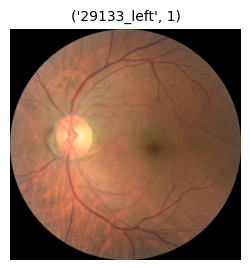

In [15]:
sample = disease.sample(1)
fname, level = sample.filename.tolist(), sample.level.tolist()

#fname, level = ['752_right.png'], [2] # #752_right
print(fname[0], level[0])
simple_plot(fname, level, img_path, fs=10)

In [16]:
ts_img, np_img = load_image(cfg, img_path, fname[0])
ts_img = ts_img.to('cuda')

prediction, activation = get_prediction(conv_model, ts_img, act=True)

(2, 16, 16)
Logit distribution: 	  [0. 1.]
Probabilities: 		 0.9997, 	 Class: 1


In [18]:
l1_norm = np.sum(np.abs(activation))
l1 = 0.00015  # .00008, .00005, 00003, .0001
l1_norm, l1*l1_norm

(3450.4355, 0.51756533203125)

In [21]:
s = 512
act = cv2.resize(activation[1], dsize=(s,s), interpolation=cv2.INTER_CUBIC)
print(act.min(), act.max())
overlay = get_overlay_img(np_img, act)

-16.57682 188.28032


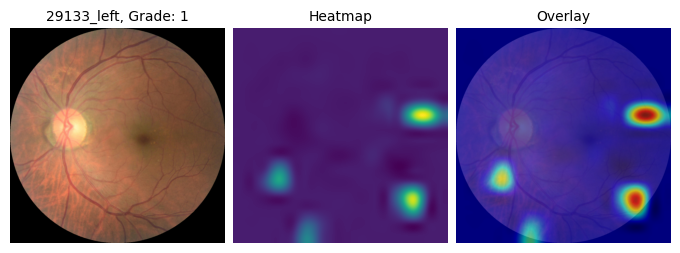

In [23]:
size = (1 * 6.69), (1 * 2.5)

format = 'png'
list_img_act_overlay = [np_img, act, overlay]
dic_title = {0: f"{fname[0][:-4]}, Grade: {level[0]}", 1:'Heatmap', 2:'Overlay'}

plot_img_heat_att(list_img_act_overlay, dic_title, size, fs=10)
#plt.savefig(f'./tmp/onset1.{format}', format=format) 

## Precision analysis

In [26]:
# annotations
anot_path = "/gpfs01/berens/data/data/DR/SparseBagNet_Clinical_study/Kaggle_annotation_512/combined_masks"
fnames = os.listdir(anot_path)
len(fnames)

65

In [28]:
data = pd.read_csv(os.path.join(model_weights, 'csv_files/resnet/small_bagnet_inference_annotations.csv')) 
#out.to_csv(f'{model_weights}csv_files/small_resnet_bagnet_65_annotation.csv', index=False)
data['bin_grade'] = 1
data = data[['filename', 'gt_level', 'bin_grade', 'res_pred', 'res_conf']] # 
print(data.shape)
data.head(3)

(65, 5)


filename  gt_level  bin_grade  res_pred  res_conf
0  21025_right.png         1          1         0     0.171
1  41725_right.png         1          1         1     0.990
2   21982_left.png         1          1         0     0.181

In [34]:
# predicition with FConv model  ~ conv_model 
out, activation, preds = get_pred_with_heatmap(cfg, conv_model, data, img_path, cname='conv_res', res=False, att=False) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 62.64it/s]


In [39]:
print(out.shape)
print(f'res: {round(accuracy_score(out.bin_grade, out.res_pred), 3)}, \t  conv res: {round(accuracy_score(out.bin_grade, out.conv_res_pred), 3)}')
out.head(3)

(65, 7)
res: 0.815, 	  conv res: 0.8


filename  gt_level  bin_grade  res_pred  res_conf  conv_res_pred  \
0  21025_right.png         1          1         0     0.171              0   
1  41725_right.png         1          1         1     0.990              1   
2   21982_left.png         1          1         0     0.181              0   

   conv_res_conf  
0          0.103  
1          0.997  
2          0.189

In [45]:
anot_fname = out.filename.tolist()

out2 = out[(out.res_pred==1) & (out.conv_res_pred==1)]
pred2 = out.conv_res_pred.tolist()

print(len(out), len(out2)) 

65 51


In [55]:
# overall precision with soft overlapping patch
overall_prec, score = get_precision(activation, anot_path, preds, thresh=1)

65it [00:01, 49.11it/s] 


In [400]:
print(score, round(overall_prec[overall_prec.predict==1]['labels'].mean(), 3))
out_prec.head(3)

0.448 0.488


filename      coords  scores         min_max  labels  predict
0  21025_right.png  (248, 248)       8  (-14.38, 8.03)       0        0
1  21025_right.png  (320, 248)       4  (-14.38, 8.03)       0        0
2  21025_right.png  (432, 312)       3  (-14.38, 8.03)       1        0

In [67]:
# overall precision with non overlapping patches
overall_prec2, score2, patch_scores = get_non_overlap_precision(activation, preds, img_path, anot_path, thresh=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 313.61it/s]


In [69]:
print(score2, round(overall_prec2[overall_prec2.predict==1]['labels'].mean(), 3))
overall_prec2.head(3)

0.187 0.201


filename      coords  scores  labels  predict
0  21025_right.png  (264, 247)   8.170       0        0
1  21025_right.png  (231, 247)   7.448       0        0
2  21025_right.png  (264, 280)   5.712       0        0

In [85]:
# topk precision
topk_precs, topk_conv_scores, topk_conv_scores_tp = get_topk_precision(activation, preds, anot_path, thresh=1, k=30)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


In [88]:
print(f'All: {topk_conv_scores} \nTP : {topk_conv_scores_tp}')
topk_tmp = topk_precs[2]
topk_tmp.head(3)

All: [0.585, 0.508, 0.492, 0.47, 0.458, 0.437, 0.42, 0.415, 0.404, 0.398, 0.399, 0.398, 0.394, 0.393, 0.394, 0.395, 0.394, 0.394, 0.393, 0.393, 0.393, 0.393, 0.393, 0.393, 0.393, 0.393, 0.393, 0.393, 0.393] 
TP : [0.673, 0.587, 0.558, 0.532, 0.516, 0.49, 0.472, 0.468, 0.454, 0.443, 0.441, 0.438, 0.433, 0.431, 0.431, 0.432, 0.43, 0.43, 0.429, 0.429, 0.429, 0.429, 0.429, 0.429, 0.429, 0.429, 0.429, 0.429, 0.429]


filename      coords   scores           min_max  labels  predict
0  21025_right.png  (248, 248)    8.026    (-14.38, 8.03)       0        0
1  21025_right.png  (320, 248)    4.682    (-14.38, 8.03)       0        0
2  41725_right.png  (192, 192)  238.406  (-10.24, 238.41)       1        1

In [402]:
topk_prec2, topk_score2, topk_scores_tp2  = get_topk_non_overlap_precision(activation, preds, img_path, anot_path, thresh=1, k=30)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.23it/s]


In [403]:
print(f'All: {topk_score2} \nTP : {topk_scores_tp2}')
topk_tmp = topk_prec2[2]
topk_tmp.head(3)

All: [0.431, 0.385, 0.344, 0.312, 0.295, 0.279, 0.279, 0.285, 0.287, 0.282, 0.281, 0.285, 0.28, 0.274, 0.266, 0.262, 0.262, 0.256, 0.253, 0.249, 0.248, 0.245, 0.243, 0.239, 0.234, 0.234, 0.232, 0.23, 0.228] 
TP : [0.519, 0.462, 0.397, 0.361, 0.342, 0.327, 0.327, 0.334, 0.335, 0.327, 0.325, 0.329, 0.324, 0.316, 0.306, 0.299, 0.3, 0.293, 0.288, 0.284, 0.283, 0.279, 0.278, 0.273, 0.267, 0.267, 0.266, 0.263, 0.259]


filename      coords      scores  labels  predict
0  21025_right.png  (264, 247)    8.170000       0        0
1  21025_right.png  (231, 247)    7.448000       0        0
2  41725_right.png  (198, 200)  241.429001       0        1

### Posthoc analysis

In [103]:
df = pd.read_csv(os.path.join(model_weights, 'csv_files/bag_res.csv'))

ffnames = list(activation.keys())
#ffnames = out2.filename.tolist()

target_layer = model.layer4[1].conv2 # Adjust based on the model architecture
layer_gc = LayerGradCam(model, target_layer)

smooth_grad_cam = NoiseTunnel(layer_gc) # Wrap LayerGradCam with NoiseTunnel

xai = {'GuidedBackprop': GuidedBackprop(model), 'IntegratedGradients': IntegratedGradients(model),
      'GradCam': LayerGradCam(model, target_layer)} # 'Smooth_GradCam': smooth_grad_cam

In [107]:
# get attributions from each method
attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.18it/s]


In [110]:
score_lists, score_tp_lists, df_outs = {}, {}, {}
xai_name = list(xai.keys()) # list of saliency methods

score_lists['conv_resnet'] = topk_conv_scores
score_tp_lists['conv_resnet'] = topk_conv_scores_tp

for name in xai_name:
    df_out, scores, scores_tp = get_topk_precision(attrib_dic, preds, anot_path, thresh=0.003, k=30, posthoc=name)
    df_outs[name] = df_out
    score_lists[name] = scores
    score_tp_lists[name] = scores_tp

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


In [111]:
attrib_dic['GradCam']['41725_right.png'].max()

0.042348225

## Plot precision

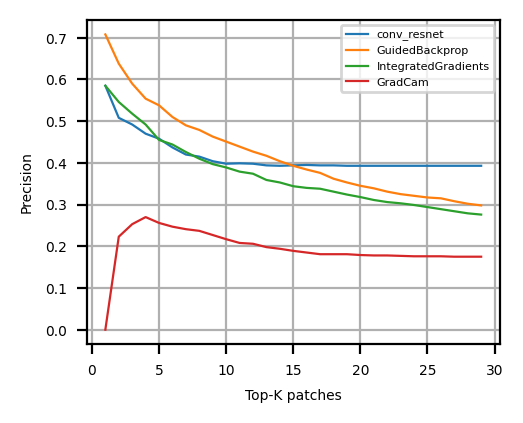

In [139]:
plot_precision(score_lists, bb=30, fs=7, lfs=4, size=(2.5,2)) #score_tp_lists, score_lists
#plt.savefig(f'./tmp/precision.{format}', format=format) 

## Sensitivity / Faithfulness

In [142]:
print(test.shape)
ttt = test.sample(10).reset_index(drop=True)

test2 = test[['filename', 'onset1']]
ttt = ttt[['filename', 'onset1']]

(6956, 8)


In [143]:
df_test = pd.read_csv(f'{model_weights}csv_files/resnet/test_fundus.csv')
print(df_test.shape)
df_test.head(3)

(6956, 6)


filename  onset1  res_pred  res_conf  cres_pred  cres_conf
0  13_left.png       0         0     0.099          0      0.032
1  40_left.png       1         1     0.994          1      0.998
2  46_left.png       0         0     0.161          0      0.016

In [246]:
df_test.onset1.value_counts()

onset1
0    5118
1    1838
Name: count, dtype: int64

In [147]:
# good predictions
good_pred = df_test[(df_test.res_pred==1) & (df_test.cres_pred==1) & (df_test.onset1==1)].copy()
print(good_pred.shape)

(1428, 6)


In [148]:
good_pred_conf = good_pred[(good_pred.res_conf>0.6) & (good_pred.res_conf<0.95) & (good_pred.cres_conf<0.9)]
sort_df = good_pred_conf.sort_values(by=['res_conf', 'cres_conf'], ascending=False).reset_index(drop=True)
final_df = sort_df[:50]

print(good_pred_conf.shape)
final_df.head(3)

(118, 6)


filename  onset1  res_pred  res_conf  cres_pred  cres_conf
0  5027_left.png       1         1     0.948          1      0.770
1  427_right.png       1         1     0.947          1      0.777
2  5634_left.png       1         1     0.938          1      0.791

In [154]:
n = 100
final_df = good_pred.sample(n, random_state=0).reset_index(drop=True)
final_fnames = final_df.filename.tolist()
final_df.head(3)

filename  onset1  res_pred  res_conf  cres_pred  cres_conf
0   21704_left.png       1         1     1.000          1       1.00
1  19197_right.png       1         1     0.879          1       0.61
2   20401_left.png       1         1     1.000          1       1.00

In [52]:
#out, activation, _ = get_pred_with_heatmap(cfg, conv_model, df_test, img_path, cname='cres', res=False, att=False) 

#out.to_csv(f'{model_weights}csv_files/resnet/test_fundus.csv', index=False) 

# Saving the object to a pickle file
#with open(f'{model_weights}csv_files/resnet/fundus_activations.pkl', 'wb') as file:  # Use 'wb' for writing in binary mode
#    pickle.dump(activation, file)

In [152]:
# Reading the pickle file
with open(f'{model_weights}csv_files/resnet/fundus_activations.pkl', 'rb') as file:  # Use 'rb' for reading in binary mode
    activations = pickle.load(file)

In [247]:
acts = {fname: activations[fname] for fname in final_fnames}
non_overlap_patch_scores = get_non_overlap_patches_scores(acts, img_path, bar=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.77it/s]


In [310]:
random_activations = get_random_activation(final_fnames)
no_rand_patch_scores = get_non_overlap_patches_scores(random_activations, img_path, bar=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.64it/s]


In [264]:
df_prec_sens = get_precision_sensitivity(acts, thresh=0)

100it [00:05, 17.91it/s]


In [265]:
print(df_prec_sens.shape)
print(df_prec_sens.filename.value_counts().min(), sens_prec.filename.value_counts().max())
df_prec_sens.head(3)

(2269, 4)
14 32


filename      coords   scores          min_max
0  21704_left.png  (328, 400)  247.616  (-14.0, 247.62)
1  21704_left.png  (104, 152)  116.951  (-14.0, 247.62)
2  21704_left.png   (48, 304)   77.271  (-14.0, 247.62)

In [262]:
patch_scores = get_overlap_patches_scores(df_prec_sens)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2269/2269 [00:02<00:00, 823.17it/s]


In [363]:
non_overlap_rand_patch_scores
dic_rand_del, rand_perf, dic_rand_imgs = get_deletion_analysis(cfg, conv_model, no_rand_patch_scores, img_path, k=15, act=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.62s/it]


In [364]:
#patch_scores
dic_deletion, perform, dic_imgs = get_deletion_analysis(cfg, conv_model, patch_scores, img_path, k=15, act=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.62s/it]


In [365]:
#non_overlap_patch_scores
dic_deletion2, perform2, dic_imgs2 = get_deletion_analysis(cfg, conv_model, non_overlap_patch_scores, img_path, k=15, act=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.63s/it]


In [366]:
print(len(rand_perf), rand_perf)
print(len(perform), perform)
print(len(perform2), perform2)

14 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 0.99]
14 [0.85, 0.81, 0.76, 0.75, 0.72, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
14 [0.88, 0.87, 0.84, 0.82, 0.82, 0.79, 0.75, 0.75, 0.72, 0.69, 0.68, 0.68, 0.66, 0.65]


In [367]:
tmp_fname = random.sample(final_fnames, 3)
print(tmp_fname)

['36722_left.png', '29864_right.png', '12441_left.png']


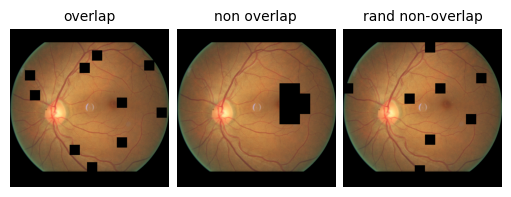

In [368]:
i, j=1, 10
list_imgs = [dic_imgs[j][tmp_fname[i]], dic_imgs2[j][tmp_fname[i]], dic_rand_imgs[j][tmp_fname[i]]]
dic_title = {0: "overlap", 1:'non overlap', 2:'rand non-overlap'}

plot_img_heat_att(list_imgs, dic_title, size=(5,10), fs=10)

In [369]:
dic_deletion[14].head(3)

filename  label  preds  hats  occ_pred  occ_hat
0   21704_left.png      1   1.00     1     0.992        1
1  19197_right.png      1   0.61     1     0.120        0
2   20401_left.png      1   1.00     1     0.999        1

In [370]:
dic_deletion2[14].head(3)

filename  label  preds  hats  occ_pred  occ_hat
0   21704_left.png      1   1.00     1     0.971        1
1  19197_right.png      1   0.61     1     0.173        0
2   20401_left.png      1   1.00     1     0.999        1

In [298]:
#plot_deletion_curve(performances, label='Deletion Curve', frac=False, fs=7, lfs=4, size=(2.5,2))

[1.0, 0.88, 0.87, 0.84, 0.82, 0.82, 0.79, 0.75, 0.75, 0.72, 0.69, 0.68, 0.68, 0.66, 0.65]
area under the deletion curve: 0.7696428571428573


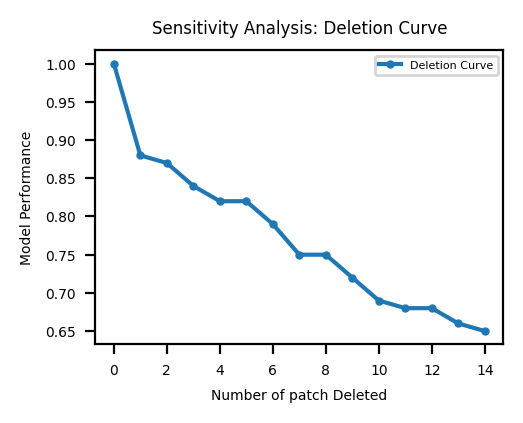

In [358]:
plot_deletion_curve(perform2, label='Deletion Curve', frac=False, fs=7, lfs=4, size=(2.5,2))

In [371]:
# plot change with respect to the random baseline
change = np.array(rand_perf) - np.array(perform2)
print(change)

[0.12 0.13 0.16 0.18 0.18 0.21 0.24 0.24 0.27 0.3  0.32 0.32 0.34 0.34]


In [381]:
### Sparse model analysis

In [410]:
test_reg = [(0.898, 0.925, 0, '0'), (0.903, 0.924, 1e-05, '1e5'), (0.900,0.926,  3e-05, '3e5'), (0.895, 0.923, 5e-05, '5e5'), 
            (0.900, 0.924, 8e-05, '8e5'), (0.899, 0.925, 1.2e-4, '12e4'), (0.897, 0.923, 1.5e-4, '15e4'), 
            (0.902, 0.917, 2e-4, '2e4'), (0.900, 0.916, 2.5e-4,'25e4'), (0.893, 0.910, 3e-4, '3e4'), 
            (0.895, 0.902, 3.5e-4, '35e4'), (0.888, 0.914, 4e-4, '4e4'), (0.849, 0.907, 5e-4, '5e4')]

model_surfix = [elt[3] for elt in test_reg]
model_reg = [elt[2] for elt in test_reg]

print(model_surfix)

['0', '1e5', '3e5', '5e5', '8e5', '12e4', '15e4', '2e4', '25e4', '3e4', '35e4', '4e4', '5e4']


In [388]:
prefix = '_best_validation_weights_acc.pt'
model_path = '../Model_weights/Fully_ConvNet/ResNet50/fundus/reg'

In [404]:
def run_eval(cfg, df, model_surf, pref, model_p, anot_p, thresh=1, k=30):
    overall_prec = []
    topk_prec = {}
    
    for i, surf in tqdm(enumerate(model_surf)):
        cmodel = torch.load(os.path.join(model_p, surf + pref), weights_only=False)
        cmodel = cmodel.to('cuda')
        cmodel.eval()
        
        _, acti, pred_ = get_pred_with_heatmap(cfg, cmodel, df, img_path, cname='conv_res', res=False, att=False, bar=False) 
        _, score = get_precision(acti, anot_p, pred_, thresh=thresh, bar=False)
        overall_prec.append(score)

        _, topk_conv_scores, topk_conv_scores_tp = get_topk_precision(acti, pred_, anot_p, thresh=thresh, k=k, bar=False)
        topk_prec[surf] = (topk_conv_scores, topk_conv_scores_tp)
        #break
    return overall_prec, topk_prec

In [470]:
def plot_overall_precision(reg_prec, marker='o', i=0, fs=12, size=(11, 8)):
    '''
        description: area under the deletion curve
    '''
    fig, ax = plt.subplots(figsize=size, facecolor= "white", dpi=200, layout="constrained")
    plt.rcParams['font.size'] = f'{fs-2}'

    reg = [elt[0] for elt in reg_prec]
    prec = [elt[1] for elt in reg_prec]      

    ax.plot(reg, prec, marker=marker, markersize=2)
    ax.scatter(reg[i], prec[i], c='r')
    #plt.xscale('log')
    ax.set_xlabel('Regularization') #
    ax.set_ylabel('Overall precision')
    ax.set_title('Precision Analysis')

In [408]:
preci, topk_preci = run_eval(cfg, data, model_surfix, prefix, model_path, anot_path, thresh=1, k=15)

13it [01:56,  8.99s/it]


[(0, 0.393), (1e-05, 0.417), (3e-05, 0.419), (5e-05, 0.52), (8e-05, 0.47), (0.00012, 0.442), (0.00015, 0.451), (0.0002, 0.525), (0.00025, 0.45), (0.0003, 0.486), (0.00035, 0.455), (0.0004, 0.393), (0.0005, 0.47)]


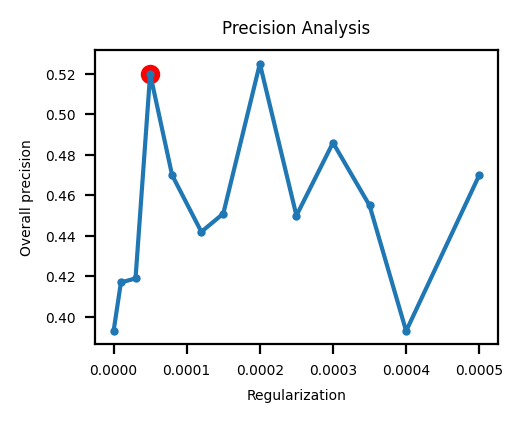

In [471]:
preci_reg = list(zip(model_reg, preci))
sorted_list = sorted(preci_reg)
print(sorted_list)

plot_overall_precision(sorted_list, i=3, fs=7, size=(2.5,2))

In [465]:
def plot_topk_reg(topk_dic, i=0, marker='o', fs=12, lfs=8, size=(11, 8)):
    '''
        description: area under the deletion curve
    '''
    fig, ax = plt.subplots(figsize=size, facecolor= "white", dpi=200, layout="constrained")
    plt.rcParams['font.size'] = f'{fs-2}'
    xx = range(0, len(topk_dic['0'][0]))
    print(list(xx))

    for key, val in topk_dic.items():
        ax.plot(xx, val[i], marker=marker, markersize=1, linewidth=0.5, label=key)
        
    ax.set_xlabel('Topk patches') #
    ax.set_ylabel('Precision')
    ax.set_title('Precision Analysis')
    #ax.legend(fontsize=lfs)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=lfs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


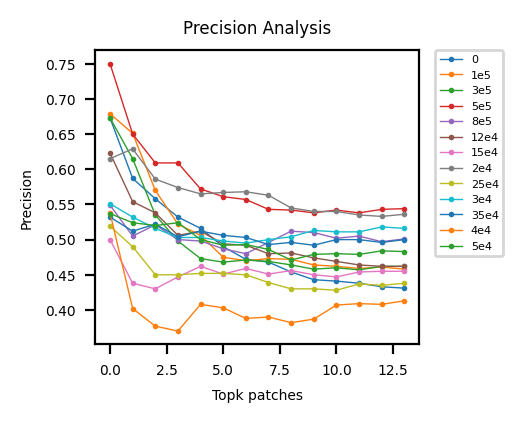

In [467]:
plot_topk_reg(topk_preci, i=1, fs=7, lfs=4, size=(2.5,2))

# Multitasks

In [122]:
#from torchvision import models

In [123]:
#model = models.resnet50()
#model.fc = torch.nn.Linear(2048, 5)
#model.load_state_dict(torch.load(model_weight, weights_only=False), strict=True)
#torch.save(obj=model, f='mullti_class_resnet_best_validation_weights_acc.pt')

In [56]:
model_weight = model_weights + 'mullti_class_resnet_best_validation_weights_acc.pt'
multi_model = torch.load(model_weight, weights_only=False)
multi_model = multi_model.to('cuda')
multi_model.eval()
print()

In [57]:
model_weight = model_weights + 'fc_resnet_multi_best_validation_weights_acc.pt'
multi_conv_model = torch.load(model_weight, weights_only=False)
multi_conv_model = multi_conv_model.to('cuda')
multi_conv_model.eval()
print()

In [238]:
2048/16

128.0

## Inference

36294_right.png 2


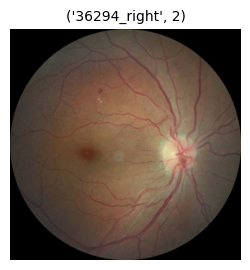

In [58]:
sample = disease.sample(1)
fname, level = sample.filename.tolist(), sample.level.tolist()

print(fname[0], level[0])
simple_plot(fname, level, path, fs=10)

In [60]:
ts_img, np_img = load_image(cfg, img_path, fname[0])
ts_img = ts_img.to('cuda')

prediction, activation, _ = multi_conv_model(ts_img)
#prediction = multi_model(ts_img)

prediction = prediction.data.cpu()
activation = activation[0].detach().cpu().numpy()
print(activation.shape) # , att_weight.shape

dist = Categorical(logits=prediction)
pred, yhat = torch.topk(dist.probs, 1)

y_prob = torch.nn.functional.softmax(prediction, dim=1)
y_prob = np.round(y_prob.numpy(), 3)
y_class = np.argmax(y_prob, axis = 1)

#print('Logit distribution: \t ', prediction.numpy()[0])
print('Logit distribution: \t ', y_prob[0])
print(f'Probabilities: \t\t {round(pred.item(), 4)}, \t Class: {yhat.item()}')

(5, 16, 16)
Logit distribution: 	  [0.    0.006 0.852 0.12  0.022]
Probabilities: 		 0.8524, 	 Class: 2


In [61]:
s = 512
act = {}
overlay = {}
for i in range(len(activation)):
    act[i] = cv2.resize(activation[i], dsize=(s,s), interpolation=cv2.INTER_CUBIC)
    overlay[i] = get_overlay_img(np_img, act[i], alpha=0.6)

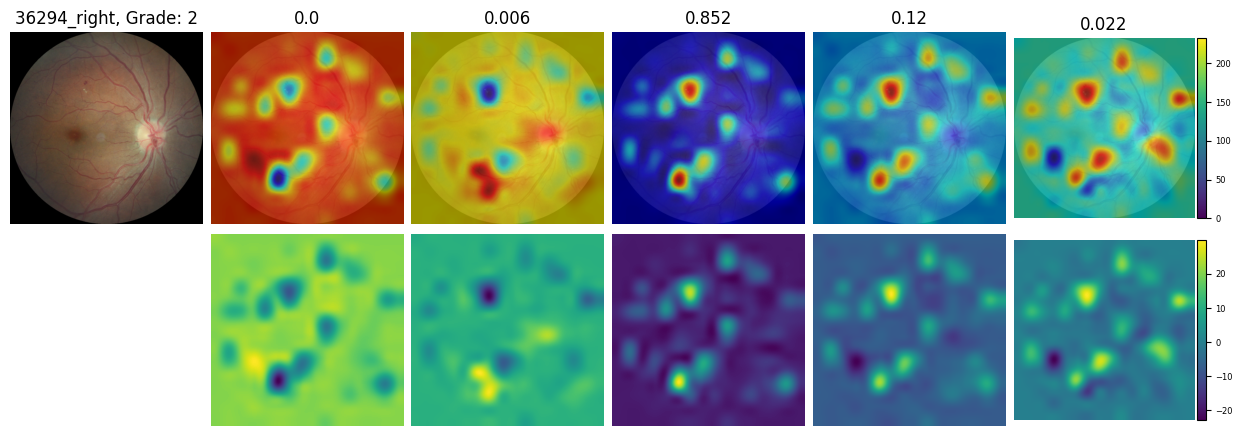

In [62]:
size = (1.8 * 6.69), (1.7 * 2.5) 

title = f"{fname[0][:-4]}, Grade: {level[0]}"
plot_img_multi_heat_att(np_img, title, overlay, act, y_prob[0], size, fs=12)
#plt.savefig(f'./tmp/multi.{format}', format=format) 

In [64]:
explainer = GuidedBackprop(multi_res_model)
explainer2 = IntegratedGradients(multi_res_model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer, v2=False, s=512)

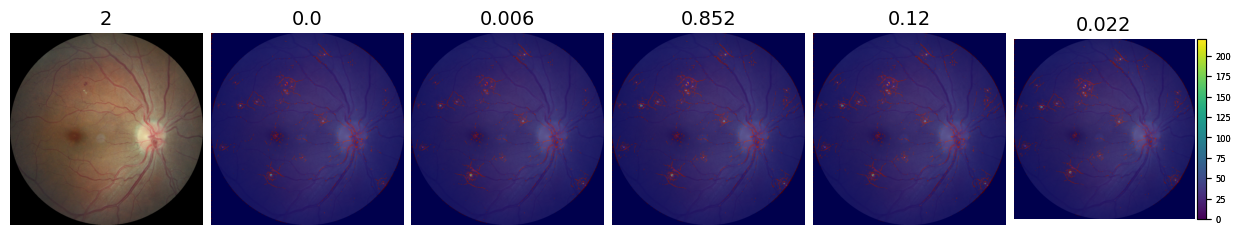

In [65]:
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, y_prob[0], size, fs=14)

# Retinal OCT 

In [12]:
cnames = ['patient_id', 'filenames', 'level']
model_weights = '../Model_weights/Fully_ConvNet/'
path = "/gpfs01/berens/data/data/kermani_oct/CellData/OCT_preprocessed_resized_3_channels_496/"
img_path = "/gpfs01/berens/data/data/kermani_oct/CellData/OCT_preprocessed_resized_3_channels_496/"

cfg.data.input_size = 496 
cfg.data.mean = [0.19075624644756317, 0.19075624644756317, 0.19075624644756317]
cfg.data.std  = [0.22165445983409882, 0.22165445983409882, 0.22165445983409882]

train = pd.read_csv(path + "train_normal_drusen.csv")
val   = pd.read_csv(path + "val_normal_drusen.csv")
test  = pd.read_csv(path + "test_normal_drusen.csv")
test  = test[cnames]
test.rename(columns={'filenames': 'filename'}, inplace=True)

disease = test[test.level>0].reset_index(drop=True)
healthy = test[test.level==0].reset_index(drop=True)

print(len(train), len(val), len(test))
test.head(3)

27430 7532 498


patient_id                          filename  level
0     8196333  test/DRUSEN/DRUSEN-8196333-1.png      1
1     2465519  test/DRUSEN/DRUSEN-2465519-1.png      1
2     8258303  test/DRUSEN/DRUSEN-8258303-1.png      1

## Models

In [542]:
from torchvision import models

In [28]:
#model = models.resnet50()
#model.fc = torch.nn.Linear(2048, 2)
#model.load_state_dict(torch.load(model_weight, weights_only=False), strict=True)
#torch.save(obj=model, f='best_validation_weights_acc_m.pt')

In [29]:
folder = 'ResNet50/'
model_weight = model_weights + folder + 'oct_resnet_best_validation_weights_acc.pt'
model = torch.load(model_weight, weights_only=False)
model = model.to('cuda')
model.eval()
print()

In [15]:
model_weight = model_weights + folder + 'oct_conv_resnet_best_validation_weights_acc.pt'
conv_model = torch.load(model_weight, weights_only=False)
conv_model = conv_model.to('cuda')
conv_model.eval()
print()

## Inference

test/DRUSEN/DRUSEN-6322301-2.png 1


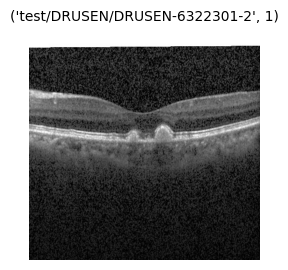

In [31]:
sample = disease.sample(1)
fname, level = sample.filename.tolist(), sample.level.tolist()

print(fname[0], level[0])
simple_plot(fname, level, img_path, fs=10)

In [32]:
ts_img, np_img = load_image(cfg, img_path, fname[0])
ts_img = ts_img.to('cuda')
ts_img.shape, np_img.shape

(torch.Size([1, 3, 496, 496]), (496, 496, 3))

In [33]:
pred, activation = get_prediction(conv_model, ts_img, act=True)

(2, 16, 16)
Logit distribution: 	  [0. 1.]
Probabilities: 		 1.0, 	 Class: 1


In [35]:
l1_norm = np.sum(np.abs(activation))
l1 = 0.0005
l1_norm, l1*l1_norm

(3695.5308, 1.847765380859375)

In [549]:
s = cfg.data.input_size
act = cv2.resize(activation[1], dsize=(s,s), interpolation=cv2.INTER_CUBIC)

print(act.min(), act.max(), act.shape)
overlay = get_overlay_img(np_img, act)

-10.5096655 109.79137 (496, 496)


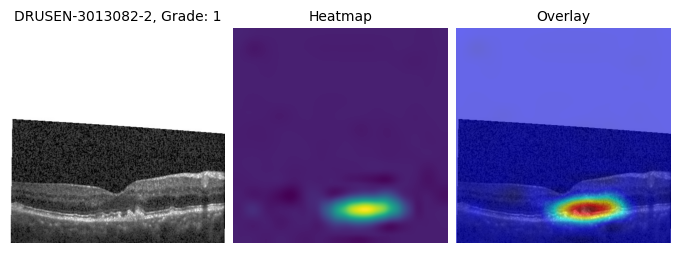

In [550]:
size = (1 * 6.69), (1 * 2.5)

format = 'png'
ll = [np_img, act, overlay]
lll = {0: f"{fname[0].split('/')[-1][:-4]}, Grade: {level[0]}", 1:'Heatmap', 2:'Overlay'}

plot_img_heat_att(ll, lll, size, fs=10)
#plt.savefig(f'./tmp/onset1.{format}', format=format) 

## Precision analysis

In [551]:
f_path = path + 'drusen_samples_v2_prototypes/'
fnames = os.listdir(f_path)

df_anot = pd.read_csv(model_weights + 'csv_files/oct/annotation_v2.csv')
df_training_anot = pd.read_csv(model_weights + 'csv_files/oct/training_img_annotation.csv')
df_anot = pd.concat([df_anot, df_training_anot])

print(df_anot.shape, df_anot.filename.nunique())
df_anot.head(3)

(252, 5) 45


filename label    x    y color
0  DRUSEN-9807719-1    DS  169  218   red
1  DRUSEN-9807719-1    DS  198  225   red
2  DRUSEN-9807719-1    DS  274  226   red

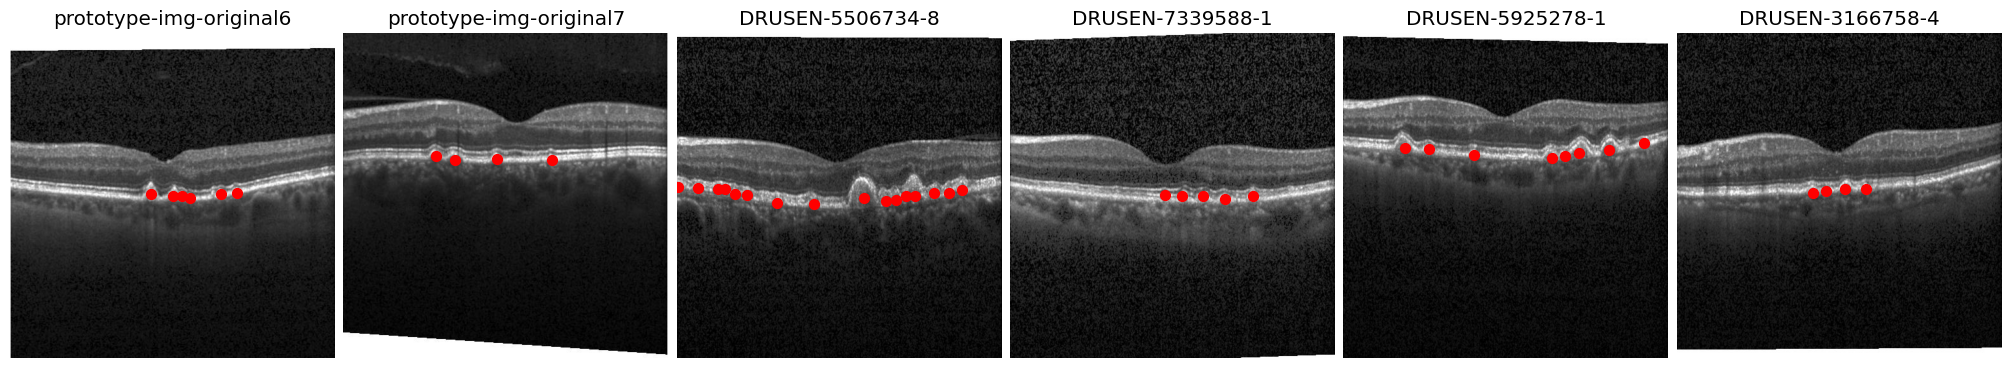

In [552]:
df_ = df_anot.sample(6).reset_index(drop=True)
plot_annotations(df_anot, f_path, s=50, nrow=1, ncol=6, size=(20,5))

In [553]:
#img = cv2.imread(f_path + 'prototype-img-original9.png')
#cv2.imwrite('prototype-img-original9.png', img)
#img.shape

In [554]:
out = model_eval(cfg, conv_model, fnames, f_path, act=True)

100%|██████████| 46/46 [00:02<00:00, 18.45it/s]


In [555]:
#df = pd.DataFrame({'filename': fnames})
#df['gt_level'] = 1
#df['res_conv_conf'] = np.round(out['predict_proba'][:, 1], decimals=3)
#df['res_conv_pred'] = out['predict_class']
#df.to_csv(f'{model_weights}csv_files/oct/inference.csv', index=False)  

In [556]:
out = pd.read_csv(f'{model_weights}csv_files/oct/inference.csv')
out.drop([15], inplace=True) # DRUSEN-7831015-1.png
print(out.shape)
round(accuracy_score(out.gt_level, out.res_pred), 3), round(accuracy_score(out.gt_level, out.res_conv_pred), 3)

(45, 6)


(1.0, 1.0)

In [557]:
out, activation = get_pred_with_heatmap(cfg, conv_model, out, f_path, s=58, att=False)

100%|██████████| 45/45 [00:00<00:00, 71.05it/s]


In [558]:
save_dir = model_weights + 'oct_masks'
masks = get_oct_masks(df_anot, f_path, save_dir)

In [559]:
out_prec, score = get_precision(activation, save_dir, thresh=1, act_size=58, round_heat=True)

100%|██████████| 45/45 [00:00<00:00, 181.53it/s]


In [560]:
score

0.533

In [561]:
out_precs, conv_scores = get_topk_precision(activation, save_dir, thresh=1, k=30, act_size=58, round_heat=True)

Method:  None


100%|██████████| 29/29 [00:05<00:00,  5.44it/s]


In [562]:
print(conv_scores)

[0.844, 0.762, 0.67, 0.594, 0.563, 0.548, 0.541, 0.537, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533, 0.533]


In [563]:
out_ = out_precs[1]
out_.head(3)

filename      coords  scores           min_max  labels
0  prototype-img-original5.png  (312, 168)     129  (-18.28, 129.96)       1
1         DRUSEN-3618354-1.png  (184, 192)     133   (-10.5, 133.42)       1
2          DRUSEN-695291-1.png  (184, 192)     133   (-10.5, 133.42)       1

In [564]:
ffnames = list(activation.keys())

target_layer = model.layer4[1].conv2 # Adjust based on the model architecture
layer_gc = LayerGradCam(model, target_layer)

smooth_grad_cam = NoiseTunnel(layer_gc) # Wrap LayerGradCam with NoiseTunnel

xai = {'GuidedBackprop': GuidedBackprop(model), 'IntegratedGradients': IntegratedGradients(model), 
      'GradCam': LayerGradCam(model, target_layer), 'Smooth_GradCam': smooth_grad_cam}

In [565]:
attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, f_path, s=58)

  0%|          | 0/45 [00:00<?, ?it/s]/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


In [566]:
score_lists, df_outs = {}, {}
xai_name = list(xai.keys())

score_lists['conv_resnet'] = conv_scores

for name in xai_name:
    df_out, scores = get_topk_precision(attrib_dic, save_dir, thresh=0.003, k=30, round_heat=False, posthoc=name, act_size=58)
    score_lists[name] = scores
    df_outs[name] = df_out

Method:  GuidedBackprop


100%|██████████| 29/29 [00:02<00:00, 11.28it/s]


Method:  IntegratedGradients


100%|██████████| 29/29 [00:02<00:00, 12.16it/s]


Method:  GradCam


100%|██████████| 29/29 [00:03<00:00,  7.38it/s]


Method:  Smooth_GradCam


100%|██████████| 29/29 [00:02<00:00, 10.39it/s]


In [567]:
df_outs['GuidedBackprop'][1].head(3)

filename      coords  scores        min_max  labels
0  prototype-img-original5.png  (176, 160)   0.561  (-0.37, 0.56)       0
1         DRUSEN-3618354-1.png  (176, 192)   0.343   (-0.3, 0.34)       1
2          DRUSEN-695291-1.png  (176, 192)   0.343   (-0.3, 0.34)       1

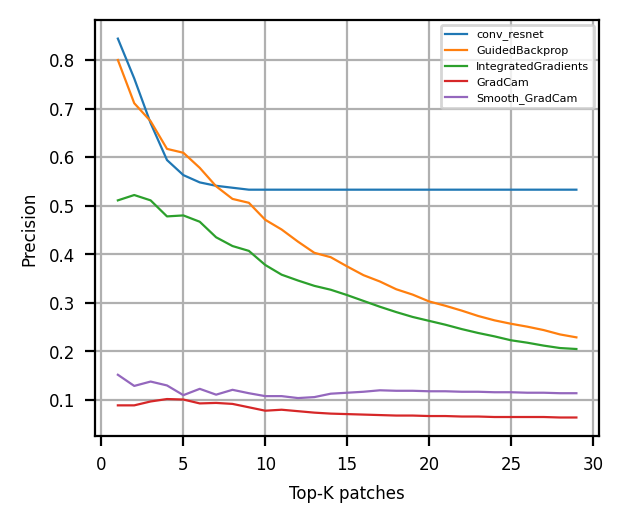

In [569]:
plot_precision(score_lists, fs=10, size=(3,2.5))

In [582]:
pred, activation = get_prediction(model, ts_img, act=False)

Logit distribution: 	  [0. 1.]
Probabilities: 		 0.9997, 	 Class: 1


/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


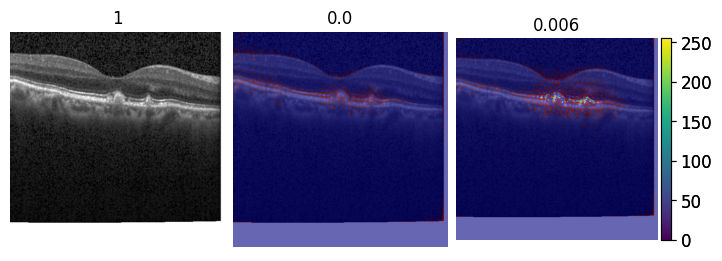

In [606]:
explainer = GuidedBackprop(model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer, v2=False, s=496, n=2)
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, y_prob[0], (6.69,2.5), nrow=1, fs=12)

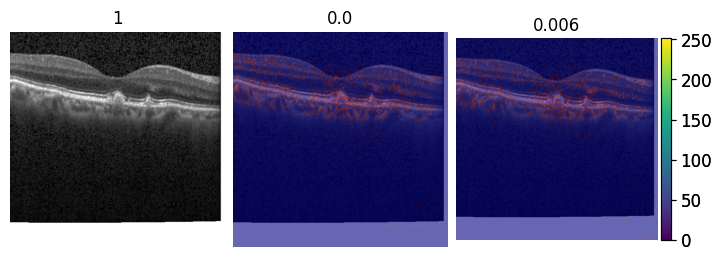

In [605]:
explainer2 = IntegratedGradients(model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer2, v2=False, s=496, n=2)
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, y_prob[0], (6.69,2.5), nrow=1, fs=12)

## RSA Pneumonia 

In [4]:
scale = 512/1024
model_weights = '../Model_weights/Fully_ConvNet/'
path = "/gpfs01/berens/data/data/ChestXray_images/RSNA_challenge/"
img_path = "/gpfs01/berens/data/data/ChestXray_images/RSNA_challenge/png_images/"

cfg.data.input_size = 512 
cfg.data.mean = [0.488974928855896, 0.488974928855896, 0.488974928855896]
cfg.data.std  = [0.2458493560552597, 0.2458493560552597, 0.2458493560552597]

train = pd.read_csv(path + 'train.csv')
val   = pd.read_csv(path + 'val.csv')
test  = pd.read_csv(path + "test.csv")

test['filename'] = test.patientId.apply(lambda x: x + '.png')
test.rename(columns={'bin_target':'level'}, inplace=True)

test = test[['filename', 'x', 'y', 'width', 'height', 'level']]

disease = test[test.level>0].reset_index(drop=True)
healthy = test[test.level==0].reset_index(drop=True)

print(len(train), len(val), len(test))
test.head(3)

11369 1264 2230


filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  637.0  276.0  188.0   282.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  638.0  319.0  258.0   458.0   
2  34a24f18-584c-41df-b0c6-2cc9fc5cc0e3.png  262.0  400.0  154.0   168.0   

   level  
0      1  
1      1  
2      1

In [5]:
all_df = pd.read_csv(path + 'stage_2_train_labels.csv')

all_df['x'] = all_df['x'] * scale 
all_df['y'] = all_df['y'] * scale
all_df['width'] = all_df['width'] * scale
all_df['height'] = all_df['height'] * scale

## Models

In [9]:
folder = 'ResNet50/rsna/'
model_weight = model_weights + folder + 'xchest_resnet_best_validation_weights_acc.pt'
model = torch.load(model_weight, weights_only=False)
model = model.to('cuda')
model.eval()
print()

In [10]:
model_weight = model_weights + folder + 'xchest_conv_resnet_best_validation_weights_acc.pt'
conv_model = torch.load(model_weight, weights_only=False)
conv_model = conv_model.to('cuda')
conv_model.eval()
print()

## Inference

ba30f407-5639-46f3-9c02-235566daed1c.png 1


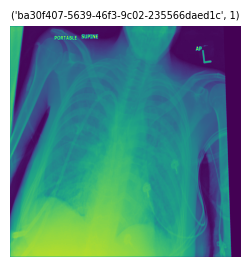

In [43]:
sample = disease.sample(1)
fname, level = sample.filename.tolist(), sample.level.tolist()
#fname = [aa]

print(fname[0], level[0])
simple_plot(fname, level, img_path, fs=7)

In [44]:
ts_img, np_img = load_image(cfg, img_path, fname[0], xchest=True)
ts_img = ts_img.to('cuda')
ts_img.shape, np_img.shape

(torch.Size([1, 3, 512, 512]), (512, 512, 3))

In [45]:
pred, activation = get_prediction(conv_model, ts_img, act=True)

(2, 16, 16)
Logit distribution: 	  [0. 1.]
Probabilities: 		 1.0, 	 Class: 1


In [46]:
l1_norm = np.sum(np.abs(activation))
l1 = 0.00005  # .00008, .00005, .0001
l1_norm, l1*l1_norm

(4308.3574, 0.21541787109375002)

In [47]:
s = cfg.data.input_size
act = cv2.resize(activation[1], dsize=(s,s), interpolation=cv2.INTER_CUBIC)

print(act.min(), act.max())
overlay = get_overlay_img(np_img, act)

-44.328995 98.35573


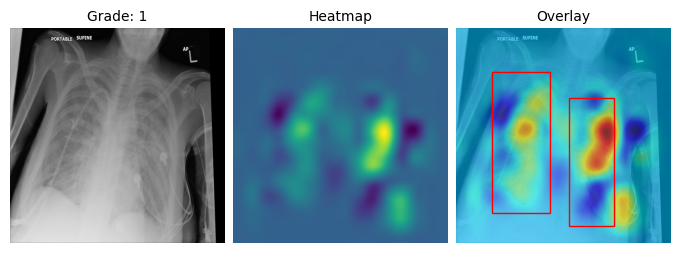

In [53]:
size = (1 * 6.69), (1 * 2.5)

format = 'png'
ll = [np_img, act, overlay]
lll = {0: f"Grade: {level[0]}", 1:'Heatmap', 2:'Overlay'}

plot_img_heat_att_v2(ll, lll, size, fs=10, df=all_df, file=fname)
#plt.savefig(f'./tmp/onset1.{format}', format=format) 

## Activation precision
Quantify what proportion of the information used to classify the image comes from the relevant region as marked by the radiologist-annotator.

In [175]:
def signed_min_max_scale(array, range_min=-1, range_max=1):
    # Separate positive and negative values
    pos_mask = array > 0
    neg_mask = array < 0

    # Scale positive values
    if np.any(pos_mask):  # Check if there are positive values
        pos_min = np.min(array[pos_mask])
        pos_max = np.max(array[pos_mask])
        array[pos_mask] = range_min + (array[pos_mask] - pos_min) * (range_max - range_min) / (pos_max - pos_min)

    # Scale negative values
    if np.any(neg_mask):  # Check if there are negative values
        neg_min = np.min(array[neg_mask])
        neg_max = np.max(array[neg_mask])
        array[neg_mask] = -range_min - (array[neg_mask] - neg_max) * (range_max - range_min) / (neg_max - neg_min)

    return array

In [223]:
def get_activation_precision(cfg, model, df, path, s=512, thresh=1):

    fnames = df.patientId.unique().tolist()
    acti2 = None
    
    for file in fnames:
        fname = file + '.png'        
        ts_img, np_img = load_image(cfg, path, fname, xchest=True)
        ts_img = ts_img.to('cuda')

        pred, activ = get_prediction(model, ts_img, act=True)
        acti = cv2.resize(activ[1], dsize=(s,s), interpolation=cv2.INTER_CUBIC)
        acti2 = acti.copy()
        acti2 = signed_min_max_scale(acti2)
        
        #acti[acti <= thresh] = 0.
        #acti[acti > thresh] = 1.
        

        mask = np.zeros((512, 512), dtype=np.uint8)
        tmp = df[df.patientId==file]
        
        for idx, row in tmp.iterrows():
            top_left = (int(row['x']), int(row['y']))
            bottom_right = (int(row['x'] + row['height']), int(row['y'] + row['width']))
            cv2.rectangle(mask, top_left, bottom_right, 1, -1)
            mask = mask / 1.
            
    return acti, mask, acti2

In [ ]:
all_df_disease = all_df[all_df.Target==1].reset_index(drop=True)

In [224]:
all_disease_fname = all_df_disease.patientId.unique().tolist()
ff = random.choice(all_disease_fname)
ff

'f125b9c8-6ea0-4378-8190-0583ef725a24'

In [225]:
df_tmp = all_df_disease[all_df_disease.patientId==ff]
df_tmp

patientId      x      y  width  height  \
8554  f125b9c8-6ea0-4378-8190-0583ef725a24  145.0  321.5   63.0    43.5   

      Target  
8554       1

In [226]:
acti, mask, acti2 = get_activation_precision(cfg, conv_model, df_tmp, img_path, thresh=1)

(2, 16, 16)
Logit distribution: 	  [0. 1.]
Probabilities: 		 1.0, 	 Class: 1


In [228]:
acti.shape, mask.shape, acti.min(), acti.max(), acti2.min(), acti2.max()

((512, 512), (512, 512), -26.954037, 178.88472, -1.0, 3.0)

In [230]:
np.sum(acti > 1), np.sum(acti2 > 1)

(125170, 69211)

In [171]:
mask.min(), mask.max(), np.unique(mask)

(0.0, 1.0, array([0., 1.]))

In [172]:
num = mask * acti
num.sum()

7154.0

In [173]:
mask.sum(), acti.sum()

(8388.0, 33625.0)

In [174]:
act_pres = (mask * acti).sum() / acti.sum()
act_pres

0.21275836431226766

## Precision analysis

In [60]:
fnames = test.filename.tolist()
len(fnames)

2230

In [44]:
out = model_eval(cfg, conv_model, fnames, img_path, act=True)

100%|██████████| 2230/2230 [01:32<00:00, 24.12it/s]


In [47]:
#df = test.copy()
#df['res_conv_conf'] = np.round(out['predict_proba'][:, 1], decimals=3)
#df['res_conv_pred'] = out['predict_class']
#df.to_csv(f'{model_weights}csv_files/rsna/inference.csv', index=False)  

In [72]:
out = pd.read_csv(f'{model_weights}csv_files/rsna/inference.csv')
out['x'] = out['x'] * scale 
out['y'] = out['y'] * scale
out['width'] = out['width'] * scale
out['height'] = out['height'] * scale

out_healthy = out[(out.level==0) & (out.res_pred==0) & (out.res_conv_pred==0)].reset_index(drop=True)
out_disease = out[(out.level==1) & (out.res_pred==1) & (out.res_conv_pred==1)].reset_index(drop=True)
print(len(out_healthy), len(out_disease))
out.head(3)

1255 810


filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  318.5  138.0   94.0   141.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  319.0  159.5  129.0   229.0   
2  34a24f18-584c-41df-b0c6-2cc9fc5cc0e3.png  131.0  200.0   77.0    84.0   

   level  res_conf  res_pred  res_conv_conf  res_conv_pred  
0      1       1.0         1          0.997              1  
1      1       1.0         1          0.999              1  
2      1       1.0         1          0.992              1

In [73]:
round(accuracy_score(out.level, out.res_pred), 3), round(accuracy_score(out.level, out.res_conv_pred), 3)

(0.953, 0.942)

In [26]:
sample = disease.sample(6).reset_index(drop=True)
#plot_annotations(df_anot, f_path, s=50, nrow=1, ncol=6, size=(20,5))

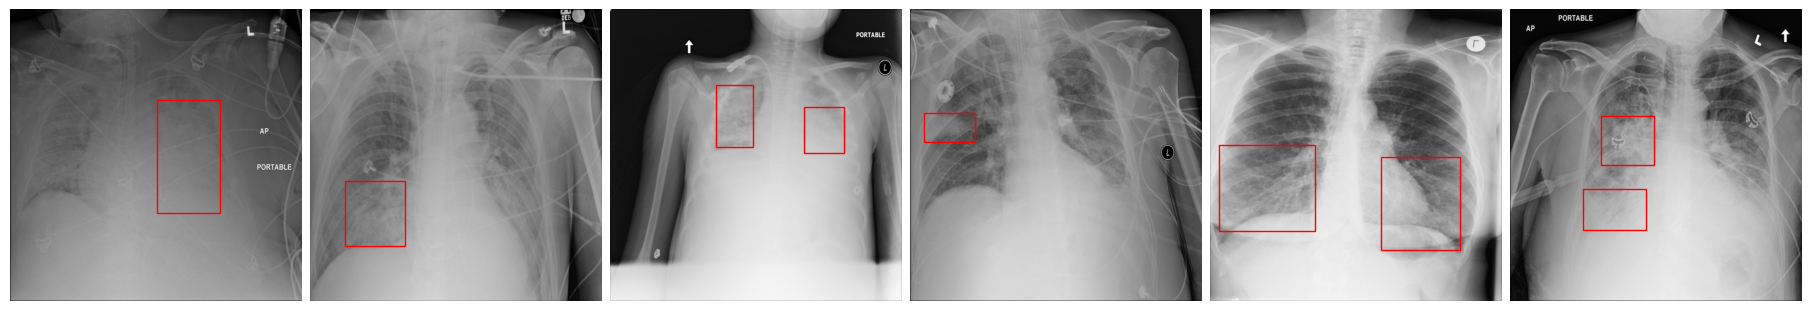

In [43]:
plot_xchest_with_bb(sample, all_df, img_path, size = (18,4))

In [504]:
tmp = all_df[all_df.patientId==aa[:-4]]
tmp

patientId      x     y  width  height  \
19891  b7a29be3-3972-4b09-8b41-04e6bc2d96d8  254.0  89.5  137.5   300.5   
19892  b7a29be3-3972-4b09-8b41-04e6bc2d96d8   86.5  97.5  106.0   238.0   

       Target  
19891       1  
19892       1

In [488]:
def plot_grid(df, ax):
     for idx, row in df.iterrows():
         rect = patches.Rectangle((row['x'], row['y']), row['width'], row['height'], linewidth=1, edgecolor='r', facecolor='none')
         ax.add_patch(rect)

def plot_grid2(ax, coord, ps=33):
     for (x, y) in coord:
         rect = patches.Rectangle((x, y), ps, ps, linewidth=1, edgecolor='r', facecolor='none')
         ax.add_patch(rect)

def scatter_plot(ax, xy, text=False):
    for i, (x, y) in enumerate(xy):
        ax.scatter(x,y, c='g')
        if text:
            ax.text(x+10,y, i)

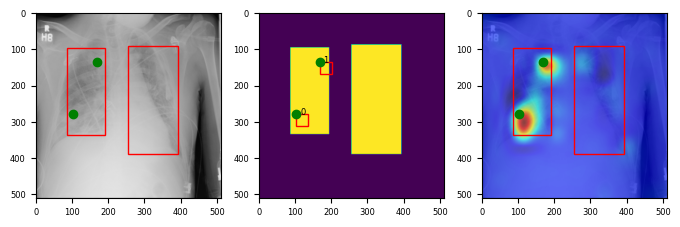

In [505]:
n =2
fig = plt.figure(figsize=size, layout='constrained')

img = Image.open(os.path.join(img_path, aa)).convert('RGB').resize((512,512))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.asarray(img))
plot_grid(tmp, ax)
scatter_plot(ax, coords[:n])

ax = fig.add_subplot(1, 3, 2)
img = plt.imread(save_dir + '/' + aa)
ax.imshow(img)
plot_grid2(ax, coords[:n])
scatter_plot(ax, coords[:n], text=True)

ax = fig.add_subplot(1, 3, 3)
ax.imshow(overlay)
plot_grid(tmp, ax)
scatter_plot(ax, coords[:n])


1


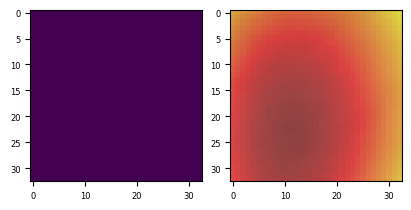

In [510]:
i = 0
ps = 33
fig = plt.figure(figsize=(4,2), layout='constrained')
mask = plt.imread(save_dir + '/' + aa)
x, y = coords[i][0], coords[i][1]
m = mask[y:y+ps, x:x+ps]
print(int(m.max()))
m2 = overlay[y:y+ps, x:x+ps, :]

ax = fig.add_subplot(1, 2, 1)
ax.imshow(m)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(m2)

In [295]:
disease.head(3)

filename      x      y  width  height  \
0  4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  637.0  276.0  188.0   282.0   
1  d7545025-6654-4cc3-83d1-99a34476c72a.png  638.0  319.0  258.0   458.0   
2  34a24f18-584c-41df-b0c6-2cc9fc5cc0e3.png  262.0  400.0  154.0   168.0   

   level  
0      1  
1      1  
2      1

In [303]:
aa = '4b048bdc-0a0a-43ed-aa0d-5971e433874b.png'
aa[:-4]

'4b048bdc-0a0a-43ed-aa0d-5971e433874b'

In [299]:
all_df[all_df.patientId=='4b048bdc-0a0a-43ed-aa0d-5971e433874b']

patientId      x      y  width  height  \
5950  4b048bdc-0a0a-43ed-aa0d-5971e433874b  637.0  276.0  188.0   282.0   
5951  4b048bdc-0a0a-43ed-aa0d-5971e433874b  356.0  144.0  193.0   367.0   

      Target  
5950       1  
5951       1

In [309]:
save_dir = model_weights + 'rsna_masks'
save_xchest_masks(out_disease, all_df, img_path, save_dir, s=512)

100%|██████████| 810/810 [00:06<00:00, 134.55it/s]


In [516]:
out_disease_ = out_disease.sample(50, random_state=0)

In [517]:
out, activation = get_pred_with_heatmap(cfg, conv_model, out_disease_, img_path, s=60, att=False)

100%|██████████| 50/50 [00:02<00:00, 24.39it/s]


In [518]:
out_prec, score = get_precision(activation, save_dir, thresh=1, act_size=60, xchest=True, round_heat=True)

100%|██████████| 50/50 [00:01<00:00, 37.39it/s]


In [519]:
score

0.275

In [522]:
out_precs, conv_scores = get_topk_precision(activation, save_dir, thresh=1, k=30, act_size=60, xchest=True, round_heat=True)

Method:  None


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


In [523]:
print(conv_scores)

[0.9, 0.79, 0.707, 0.62, 0.556, 0.5, 0.443, 0.401, 0.373, 0.347, 0.333, 0.32, 0.307, 0.298, 0.291, 0.285, 0.281, 0.277, 0.276, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275]


In [338]:
rr = random.sample(out_disease_.filename.tolist(),6)
rr

['1748e4e2-5c73-4794-81fe-2c5fe4af8cdd.png',
 '0953df2c-f969-4fa1-a872-022475ecd5ef.png',
 'c8f8c1af-28f3-420d-85d6-9501a8002097.png',
 'b7a29be3-3972-4b09-8b41-04e6bc2d96d8.png',
 'd373b335-d9d9-4594-b97e-03ec9aa8daa2.png',
 '91e187a5-771d-4a83-9601-e22ed326bc8e.png']

In [497]:
aa = rr[3]
aa

'b7a29be3-3972-4b09-8b41-04e6bc2d96d8.png'

In [528]:
aaa = out_prec[out_prec.filename==aa]
coords = aaa.coords.tolist()
aaa.head()

filename      coords  scores  \
720  b7a29be3-3972-4b09-8b41-04e6bc2d96d8.png  (104, 280)     139   
721  b7a29be3-3972-4b09-8b41-04e6bc2d96d8.png  (168, 136)     105   
722  b7a29be3-3972-4b09-8b41-04e6bc2d96d8.png  (256, 128)      22   
723  b7a29be3-3972-4b09-8b41-04e6bc2d96d8.png  (192, 248)      11   
724  b7a29be3-3972-4b09-8b41-04e6bc2d96d8.png  (376, 344)      11   

              min_max  labels  
720  (-23.53, 139.04)       1  
721  (-23.53, 139.04)       1  
722  (-23.53, 139.04)       1  
723  (-23.53, 139.04)       1  
724  (-23.53, 139.04)       1

In [532]:
ffnames = list(activation.keys())

target_layer = model.layer4[1].conv2 # Adjust based on the model architecture
layer_gc = LayerGradCam(model, target_layer)

smooth_grad_cam = NoiseTunnel(layer_gc) # Wrap LayerGradCam with NoiseTunnel

xai = {'GuidedBackprop': GuidedBackprop(model), 'IntegratedGradients': IntegratedGradients(model), 
      'GradCam': LayerGradCam(model, target_layer), 'Smooth_GradCam': smooth_grad_cam}

In [530]:
len(ffnames)

50

In [533]:
attrib_dic = get_posthoc_explanation(cfg, ffnames, xai, img_path, s=60)

  0%|          | 0/50 [00:00<?, ?it/s]/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/gpfs01/berens/user/kdjoumessi/.local/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


In [539]:
score_lists, df_outs = {}, {}
xai_name = list(xai.keys())

score_lists['conv_resnet'] = conv_scores

for name in xai_name:
    df_out, scores = get_topk_precision(attrib_dic, save_dir, thresh=0.003, k=30, xchest=True, round_heat=False, posthoc=name, act_size=60)
    score_lists[name] = scores
    df_outs[name] = df_out

Method:  GuidedBackprop


100%|██████████| 29/29 [00:02<00:00, 10.33it/s]


Method:  IntegratedGradients


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Method:  GradCam


100%|██████████| 29/29 [00:57<00:00,  1.98s/it]


Method:  Smooth_GradCam


100%|██████████| 29/29 [00:02<00:00, 13.35it/s]


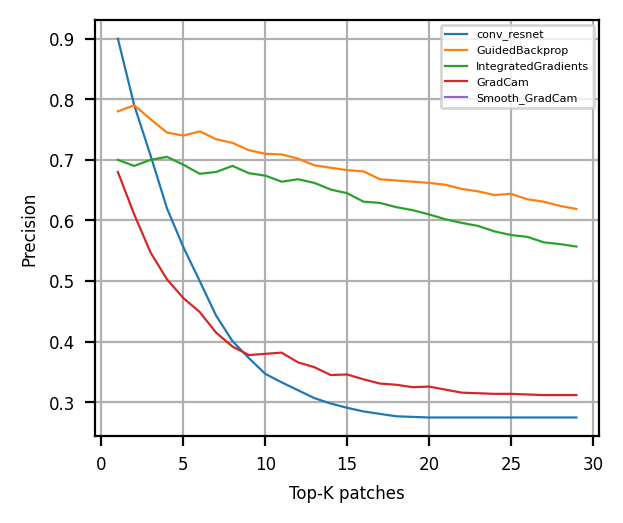

In [540]:
plot_precision(score_lists, fs=10, size=(3,2.5))

In [243]:
pred, activation = get_prediction(model, ts_img, act=False)

Logit distribution: 	  [0.055 0.945]
Probabilities: 		 0.9455, 	 Class: 1


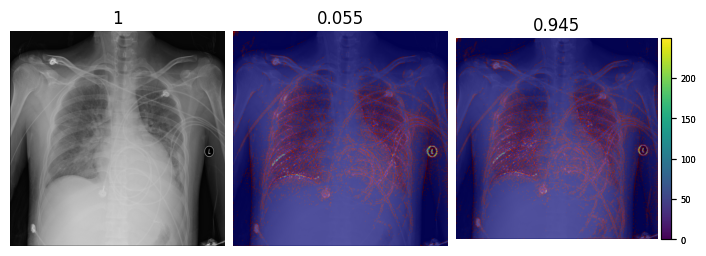

In [246]:
explainer = GuidedBackprop(model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer, v2=False, s=512, n=2)
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, pred[0], (6.69,2.5), nrow=1, fs=12)

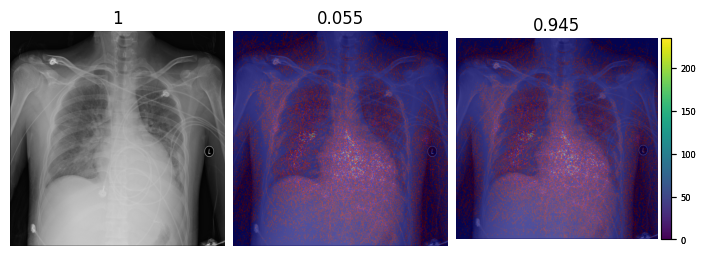

In [248]:
explainer2 = IntegratedGradients(model)
act_, overlay_ = get_single_posthoc_explanation(ts_img, np_img, explainer2, v2=False, s=512, n=2)
plot_img_multi_heat_att(np_img, level[0], overlay_, {}, pred[0], (6.69,2.5), nrow=1, fs=12)

In [287]:
def get_sensitivity_score(cfg, network, d_df, h_df, path, act=True, conv=False):
    numerator, denominator = 0, 0
    
    for idx, row in tqdm(d_df.iterrows()): 
        ts_img, _ = load_image(cfg, img_path, row['filename'])
        ts_img = ts_img.to('cuda')
        neg_act = 0

        if conv:
            prediction, activation = conv_model(ts_img)
            activation = activation[0].detach().cpu().numpy()
            activation = activation[1]
            activation[activation < 0] = 0
            
        numerator += activation.sum()
        denominator += activation.sum()

        df_tmp = h_df.sample(3, random_state=idx)
        for _, row_ in  df_tmp.iterrows():
            ts_img_, _ = load_image(cfg, img_path, row_['filename'])
            ts_img_ = ts_img_.to('cuda')

            if conv:
                prediction, acti = conv_model(ts_img_)
                acti = acti[0].detach().cpu().numpy()
                action = acti[1]
                acti[acti < 0] = 0
                denominator += acti.sum()

    sens_score =  numerator / denominator
        #break
    return sens_score

In [289]:
df_d = disease.sample(30)

In [290]:
get_sensitivity_score(cfg, conv_model, df_d, healthy, img_path, act=True, conv=True)

30it [00:07,  4.22it/s]


0.2014198449564681

In [249]:
ts_img, np_img = load_image(cfg, img_path, fname[0])
ts_img = ts_img.to('cuda')

prediction, activation, _ = conv_model(ts_img)
prediction = prediction.data.cpu()
activation = activation[0].detach().cpu().numpy()

act = cv2.resize(activation[1], dsize=(s,s), interpolation=cv2.INTER_CUBIC)

filename      x      y  width  height  \
0    4b048bdc-0a0a-43ed-aa0d-5971e433874b.png  637.0  276.0  188.0   282.0   
1    d7545025-6654-4cc3-83d1-99a34476c72a.png  638.0  319.0  258.0   458.0   
2    34a24f18-584c-41df-b0c6-2cc9fc5cc0e3.png  262.0  400.0  154.0   168.0   
3    40ef3f33-d990-4a08-b652-ed4e02e84159.png  643.0  438.0  258.0   441.0   
4    a6b8e55c-5e2a-4ee3-8731-479985e068f0.png  516.0  493.0  216.0   256.0   
..                                        ...    ...    ...    ...     ...   
897  9e6239f2-9352-4bad-a19a-22538ddd0e27.png  608.0  247.0  284.0   407.0   
898  916a0cd0-d682-43e0-aeb2-8da59c626599.png  604.0  183.0  375.0   723.0   
899  a57f578f-1e6f-4248-bd38-2dacfa772fdb.png  233.0  238.0  281.0   315.0   
900  86a6c564-e88d-4a30-9dc7-cddbab5773b5.png  495.0   91.0  222.0   420.0   
901  50533ed3-bfb4-4e56-82f7-678e03864265.png  198.0  346.0  243.0   365.0   

     level  
0        1  
1        1  
2        1  
3        1  
4        1  
..     ...  
897      1  
898      1  
899      1  
900      1  
901      1  

[902 rows x 6 columns]

In [ ]:
healthy.sample(2, random_state=)